In [1]:
import numpy as np
from var_estimation import fit_all_garch_models, compute_var_arch_model_daily, compute_var_arch_model_weekly, download_data, stationarity_tests, run_diagnostics_two_models
import random

np.random.seed(42)
random.seed(42)

"""
warnings.filterwarnings("ignore", category=ConvergenceWarning)

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*The optimizer returned code.*")
"""

'\nwarnings.filterwarnings("ignore", category=ConvergenceWarning)\n\nwarnings.filterwarnings("ignore", category=UserWarning)\nwarnings.filterwarnings("ignore", category=RuntimeWarning)\nwarnings.filterwarnings("ignore", category=DeprecationWarning)\nwarnings.filterwarnings("ignore", category=FutureWarning)\nwarnings.filterwarnings("ignore", message=".*The optimizer returned code.*")\n'

----
## GARCH-Based Value at Risk Estimation for a Multi-Asset Portfolio

This notebook implements a framework for estimating Value at Risk (VaR) using volatility models from the ARCH family. Our focus is on modeling the risk of a multi-asset portfolio through simulation-based approaches that reflect both market volatility clustering and return distribution characteristics.

We proceed in six major steps:

1. Introduction:
   - Introduction to Value at Risk (VaR) as a risk metric
   - Overview of ARCH family models for volatility forecasting

2. Setup:
   - Download historical price data for a portfolio of assets
   - Calculate daily returns and portfolio returns
   - Test for stationarity of returns

3. Model Selection:
    - Fit multiple ARCH-family models (GARCH, EGARCH, GJR-GARCH, APARCH)
    - Select best model by Akaike Information Criterion (AIC)
    - Run diagnostics like Ljung-Box and Jarque-Bera on the selected models to check residuals for autocorrelation and normality
    
4. Simulation Methods:  
   - Using the best model, we estimate both a one-day-ahead and one-week-ahead VaR under three innovation assumptions:
      - Normal-distributed innovations
      - t-distributed innovations
      - Filtered Historical Simulation (FHS)

5. Comparison & Visualization:
   - Plot simulated return distributions and VaR thresholds for time horizons
   - Compare VaR estimates across methods and time horizons
   - Discuss implications for portfolio risk management
   - Limitations and considerations for further work  

6. Conclusion and Future Work:
   - Monthly VaR estimation
   - Model diagnostic plots and residual analysis
   - Interactive widgets for parameter tuning
   - Stress testing scenarios and backtesting VaR models

---- 

## Introduction to Value at Risk (VaR) as a risk metric

The first attempts to measure risk and express potential losses in a portfolio are attributed to Francis Edgeworth in 1888. He contributed significantly to statistical theory and advocated using historical data as the basis for estimating future probabilities.

In 1945, Dickson H. Leavens made one of the earliest mentions resembling VaR by analyzing a portfolio of ten government bonds. He suggested that each bond either reaches maturity worth $1,000 or becomes worthless under certain conditions. Although he did not use the term "Value at Risk," he described "the spread between the likely profit and loss," closely related to the mean and standard deviation, key components of modern VaR.

In 1952, Harry Markowitz, later awarded the Nobel Prize in Economics in 1990 for his pioneering work in portfolio theory, independently and simultaneously with Arthur D. Roy, proposed risk indicators very similar to VaR. Both sought to optimize portfolio profit for a given level of risk. Their methods involved covariance, but their VaR indicators differed. Roy’s method required knowing average returns and the variance-covariance matrix of risk factors, estimated from historical data. Markowitz’s method only needed the variance-covariance matrix. Both emphasized combining statistical techniques with expert judgment.

During the 1970s and 1980s, the emergence of new financial products posed challenges for risk modeling due to lack of historical data. One solution was to find similar financial products and derive approximate risks. For example, the abolition of the Bretton Woods monetary system in 1971 led to the development of the foreign exchange forward market, necessitating new risk measurement approaches.

In 1971, Bernard Lietaer developed a model focused on exchange rate fluctuation risks, especially relevant post-World War II with widespread currency devaluations. His model helped optimize hedging strategies by modeling devaluation risk. Notably, Lietaer applied the Monte Carlo method, which later became standard in VaR calculations.

Although early VaR predecessors date back to the 20th century, credit for the modern VaR methodology is mainly given to the US investment bank J.P. Morgan. Chairman Dennis Weatherstone requested a simple yet comprehensive risk measure covering all bank risks over the next 24 hours. This led to the development of what was initially called the "4:15 report" based on Markowitz’s portfolio theory. The term "Value at Risk" emerged later, with earlier synonyms including "dollars at risk," "capital at risk," and "earnings at risk."

J.P. Morgan published a technical document describing VaR in 1994, which spurred widespread adoption among financial institutions. VaR became the preferred risk measure for investment banks seeking standardized risk assessment for regulatory compliance.

The Basel Committee on Banking Supervision (BCBS) was founded in 1974 after the Herstatt Bank crisis, aiming to promote banking stability globally. Basel II regulations later endorsed the use of VaR methodologies for calculating capital charges related to market risk, allowing banks to use their own proprietary VaR models.

Papers: [Mina et al 2001] and [Adamkoa et al 2015] can be found in the theory folder for further reading on the history and development of VaR.

### Value at Risk (VaR) Definition

$$
\text{VaR}_{\alpha}(h) = \inf \{ x \in \mathbb{R} : P(R_h \leq x) \geq 1 - \alpha \}
$$

where:
- $ R_h $ is the portfolio return over horizon $ h $,
- $ \alpha \in (0,1) $ is the confidence level (e.g., 0.95 or 0.99),
- $ \inf $ denotes the infimum (minimum) value such that the probability of losses exceeding VaR is at most $ 1 - \alpha $.

In practice, VaR estimates the worst expected loss not exceeded with probability $ \alpha $ during the time period $ h $.

---


## Overview of ARCH family models for volatility forecasting


The Autoregressive Conditional Heteroskedasticity (ARCH) model was introduced by Robert F. Engle in 1982, marking a major breakthrough in modeling and forecasting time-varying volatility in financial time series. Engle’s seminal paper, “Autoregressive Conditional Heteroskedasticity with Estimates of the Variance of United Kingdom Inflation”, provided a practical framework to capture volatility clustering — the empirical observation that periods of high volatility tend to be followed by high volatility, and periods of low volatility tend to be followed by low volatility.

Following the ARCH model, Tim Bollerslev (1986) extended the framework to the Generalized ARCH (GARCH) model, allowing past conditional variances to also affect current volatility. The GARCH model improved flexibility and parsimony and quickly became the standard tool in financial econometrics. Over time, several important extensions to the ARCH/GARCH family have been developed to address specific empirical phenomena:

- EGARCH (Exponential GARCH) by Nelson (1991), which models asymmetries and leverage effects in volatility without imposing non-negativity constraints on parameters.

- GJR-GARCH by Glosten, Jagannathan, and Runkle (1993), introducing asymmetric effects where negative shocks increase volatility more than positive shocks of the same magnitude.

- APARCH (Asymmetric Power ARCH) by Ding, Granger, and Engle (1993), which generalizes several GARCH-type models by allowing flexible power transformations of volatility and asymmetries.

- Additional advanced models such as FIGARCH, HYGARCH, and FIAPARCH emerged to capture long memory and persistence in volatility, providing richer modeling capabilities for complex financial data.

The ARCH family of models revolutionized volatility modeling and risk management by enabling dynamic, data-driven estimates of conditional variance. Robert Engle was awarded the Nobel Memorial Prize in Economic Sciences in 2003 for his foundational contributions to this field.

---

### ARCH(p) Model

The conditional variance depends on the past squared residuals:

$$
\sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \varepsilon_{t-i}^2
$$
where:
- $ \varepsilon_t $ are model residuals,
- $ \omega > 0 $, $ \alpha_i \geq 0 $,
- $ p $ is the order of the ARCH term.


### GARCH(p, q) Model (Generalized ARCH)

Extends ARCH by including lagged conditional variances:

$$
\sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \varepsilon_{t-i}^2 + \sum_{j=1}^q \beta_j \sigma_{t-j}^2
$$
where:
- $ \beta_j \geq 0 $,
- $ q $ is the order of GARCH terms.


### EGARCH(p, q) Model (Exponential GARCH)

Models the logarithm of conditional variance, capturing asymmetry (leverage effect):

$$
\log(\sigma_t^2) = \omega + \sum_{j=1}^q \beta_j \log(\sigma_{t-j}^2) + \sum_{i=1}^p \alpha_i \left( \frac{|\varepsilon_{t-i}|}{\sigma_{t-i}} - \mathbb{E}\left[ \frac{|\varepsilon_{t-i}|}{\sigma_{t-i}} \right] \right) + \sum_{i=1}^p \gamma_i \frac{\varepsilon_{t-i}}{\sigma_{t-i}}
$$
where:
- The $ \gamma_i $ terms capture the asymmetric impact of positive and negative shocks on volatility.


### GJR-GARCH(p, q) Model

Introduces an indicator function to allow negative shocks to have a different effect on volatility than positive shocks:

$$
\sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \varepsilon_{t-i}^2 + \sum_{i=1}^p \gamma_i \varepsilon_{t-i}^2 I_{\{\varepsilon_{t-i} < 0\}} + \sum_{j=1}^q \beta_j \sigma_{t-j}^2
$$
where:
- $ I_{\{\varepsilon_{t-i} < 0\}} $ is the indicator function (1 if the shock is negative, 0 otherwise),
- $ \gamma_i $ models the asymmetry.


### APARCH(p, q) Model (Asymmetric Power ARCH)

Generalizes GARCH by introducing a power term and asymmetry in the volatility process:

$$
\sigma_t^\delta = \omega + \sum_{i=1}^p \alpha_i \left( |\varepsilon_{t-i}| - \gamma_i \varepsilon_{t-i} \right)^\delta + \sum_{j=1}^q \beta_j \sigma_{t-j}^\delta
$$
where:
- $ \delta > 0 $ is the power parameter (estimated from data),
- $ \gamma_i $ controls the leverage effect (asymmetry),
- $ \sigma_t^\delta $ denotes the conditional standard deviation raised to the power $ \delta $.

---

## Summary

These models allow for flexible, dynamic modeling of volatility by capturing:

- Volatility clustering (periods of high volatility followed by low volatility),
- Leverage effects (asymmetric response of volatility to positive and negative returns),
- Heavy tails and changing variance over time.

They form the backbone for risk management techniques like VaR calculation, where accurate forecasts of volatility and return distribution tails are critical.


In [2]:
tickers = ['GLD', 'COST', 'TDG', 'VGK', 'ITA', 'ESP0.DE', 'IWDA.AS', 'CSP1.L', 'ARGT', 'NVDA', 'INDA']
weights = np.array([5.31, 5.32, 5.32, 5.31, 5.31, 5.32, 5.32, 5.32, 5.32, 32.82, 5.85]) / 100
portfolio_value = 100
confidence_levels = [0.95, 0.99]
simulations = 10000

data = download_data(tickers, start_date='2020-01-01', end_date='2025-04-21')
returns = data.pct_change().dropna()
portfolio_returns = returns.dot(weights)
expected_daily = portfolio_returns.mean()



[*********************100%***********************]  11 of 11 completed


## 2. Setup

This portfolio represents a set of assets I am currently managing and is not selected based on any specific criteria relevant for this project. We begin by downloading historical adjusted closing price data for these assets and calculating their daily returns, as well as the overall portfolio return. Subsequently, we test the stationarity of the portfolio returns using the Augmented Dickey-Fuller (ADF) test and the KPSS test. These tests help determine whether the time series is stationary, which is a key assumption for many time series models, including ARCH/GARCH models.

Papers [Kwiatkowski et al 1992] and [Fuller et al 1979] can be found in the theory folder for further reading on the ADF and KPSS tests.

For this notebook, we analyze a portfolio consisting of the following assets:

| Asset Name                                       | Ticker   | Weight (%) |
|-------------------------------------------------|----------|------------|
| SPDR Gold Shares                                | GLD      | 5.31       |
| Costco Wholesale Corporation                    | COST     | 5.32       |
| TransDigm Group Incorporated                    | TDG      | 5.32       |
| Vanguard FTSE Europe ETF                        | VGK      | 5.31       |
| iShares U.S. Aerospace & Defense ETF            | ITA      | 5.31       |
| VanEck Video Gaming and eSports ETF              | ESP0.DE  | 5.32       |
| iShares Core MSCI World UCITS ETF                | IWDA.AS  | 5.32       |
| iShares Core S&P 500 UCITS ETF                   | CSP1.L   | 5.32       |
| Global X MSCI Argentina ETF                      | ARGT     | 5.32       |
| NVIDIA Corporation                               | NVDA     | 32.82      |
| iShares MSCI India ETF                           | INDA     | 5.85       |

--- 

### ADF and KPSS Stationarity Tests:

#### Augmented Dickey-Fuller (ADF) Test
Purpose:  Tests the null hypothesis that a time series has a unit root (i.e., it is non-stationary).
#### Model:
The ADF test estimates the regression:
$$
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \varepsilon_t
$$
where:  
- $ y_t $ is the time series  
- $ \Delta y_t = y_t - y_{t-1} $ is the first difference  
- $ \alpha $ is a constant (drift term)  
- $ \beta t $ is a deterministic trend (optional)  
- $ p $ is the number of lagged difference terms (to remove autocorrelation)  
- $ \varepsilon_t $ is white noise error term  

#### Hypotheses:

- $ H_0: \gamma = 0 $ (unit root present → non-stationary)  
- $ H_a: \gamma < 0 $ (no unit root → stationary)

#### Test Statistic:
$$
\tau = \frac{\hat{\gamma}}{\text{SE}(\hat{\gamma})}
$$
where $\hat{\gamma}$ is the estimated coefficient on $ y_{t-1} $.

If $\tau$ is less than the critical value, reject $H_0$.

---

#### KPSS Test (Kwiatkowski–Phillips–Schmidt–Shin)
Purpose:  Tests the null hypothesis that a time series is stationary (around a level or trend).
#### Model:
The KPSS test decomposes $ y_t $ as:
$$
y_t = \delta t + \mu_t + \varepsilon_t
$$
where:  
- $ \delta t $ is deterministic trend  
- $ \mu_t $ is a random walk: $ \mu_t = \mu_{t-1} + \eta_t $, with $\eta_t \sim N(0, \sigma_\eta^2)$  
- $ \varepsilon_t $ is stationary error  

#### Hypotheses:

- $ H_0: \sigma_\eta^2 = 0 $ (series is trend stationary)  
- $ H_a: \sigma_\eta^2 > 0 $ (series is non-stationary)

#### Test Statistic:
$$
KPSS = \frac{1}{T^2} \sum_{t=1}^{T} S_t^2 / \hat{\sigma}^2
$$
where:  
- $ T $ is sample size  
- $ S_t = \sum_{i=1}^{t} \hat{\varepsilon}_i $ are cumulative residuals from regression of $ y_t $ on deterministic components  
- $ \hat{\sigma}^2 $ is an estimate of the long-run variance of $ \varepsilon_t $  

If the KPSS statistic is greater than critical values, reject $H_0$.


In [3]:
# Perform stationarity tests on the portfolio returns
print(stationarity_tests(portfolio_returns))

                      Test  Test Statistic       p-value  Stationary  \
0  Augmented Dickey-Fuller      -11.657219  1.972187e-21        True   
1                     KPSS        0.075353  1.000000e-01        True   

              Null Hypothesis  
0  Unit root (non-stationary)  
1                  Stationary  


/Users/stefan/VSCode/dynamic_var/var_estimation.py:60: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags="auto")


## 3. Model Selection 

Having established that our data is well-behaved and the portfolio returns are stationary, the next step is to fit multiple ARCH-family models to the portfolio returns. We then select the best-fitting model using the Akaike Information Criterion (AIC).

The paper, [Akaike 1974], can be found in the theory folder for further reading on the Akaike Information Criterion (AIC).

---

### Akaike Information Criterion (AIC)

The Akaike Information Criterion (AIC) is a widely used metric for model selection among a set of candidate statistical models. It balances the model’s goodness of fit with its complexity to avoid overfitting.

Mathematically, the AIC is defined as:
$$
\boxed{
\mathrm{AIC} = 2k - 2\ln(L)
}
$$
where:  
- $ k $ = number of estimated parameters in the model  
- $ L $ = maximum value of the likelihood function for the model  

#### Interpretation:

- The likelihood function $ L $ measures how well the model fits the observed data; higher $ L $ means better fit.
- The term $ 2k $ penalizes model complexity (more parameters increase this penalty).
- The goal is to minimize the AIC: lower AIC indicates a better trade-off between model complexity and fit.

#### Usage:

- When comparing multiple models fitted to the same data, the model with the lowest AIC is preferred.
- AIC helps prevent overfitting by penalizing models that use too many parameters without sufficiently improving the fit.
- It does not test the model in an absolute sense but provides a relative measure for model comparison.

In [4]:
print("Assumption of normal-distributed residuals:")
df_results_normal = fit_all_garch_models(portfolio_returns)
print(df_results_normal[['Model', 'p', 'q', 'AIC']].head(5))
model_row = df_results_normal.iloc[0]
model_result_norm = model_row['Result']

print("Assumption of t-distributed residuals:")
df_results_t = fit_all_garch_models(portfolio_returns, dist='t')
print(df_results_t[['Model', 'p', 'q', 'AIC']].head(5))
model_row_t = df_results_t.iloc[0]
model_result_t = model_row_t['Result']

Assumption of normal-distributed residuals:
        Model  p  q          AIC
14     APARCH  2  1  4563.576289
12     APARCH  1  1  4564.622854
15     APARCH  2  2  4564.972670
13     APARCH  1  2  4566.504601
8   GJR-GARCH  1  1  4568.338799
Assumption of t-distributed residuals:
        Model  p  q          AIC
14     APARCH  2  1  4495.852003
12     APARCH  1  1  4496.555721
15     APARCH  2  2  4497.194687
13     APARCH  1  2  4498.494435
8   GJR-GARCH  1  1  4501.781124


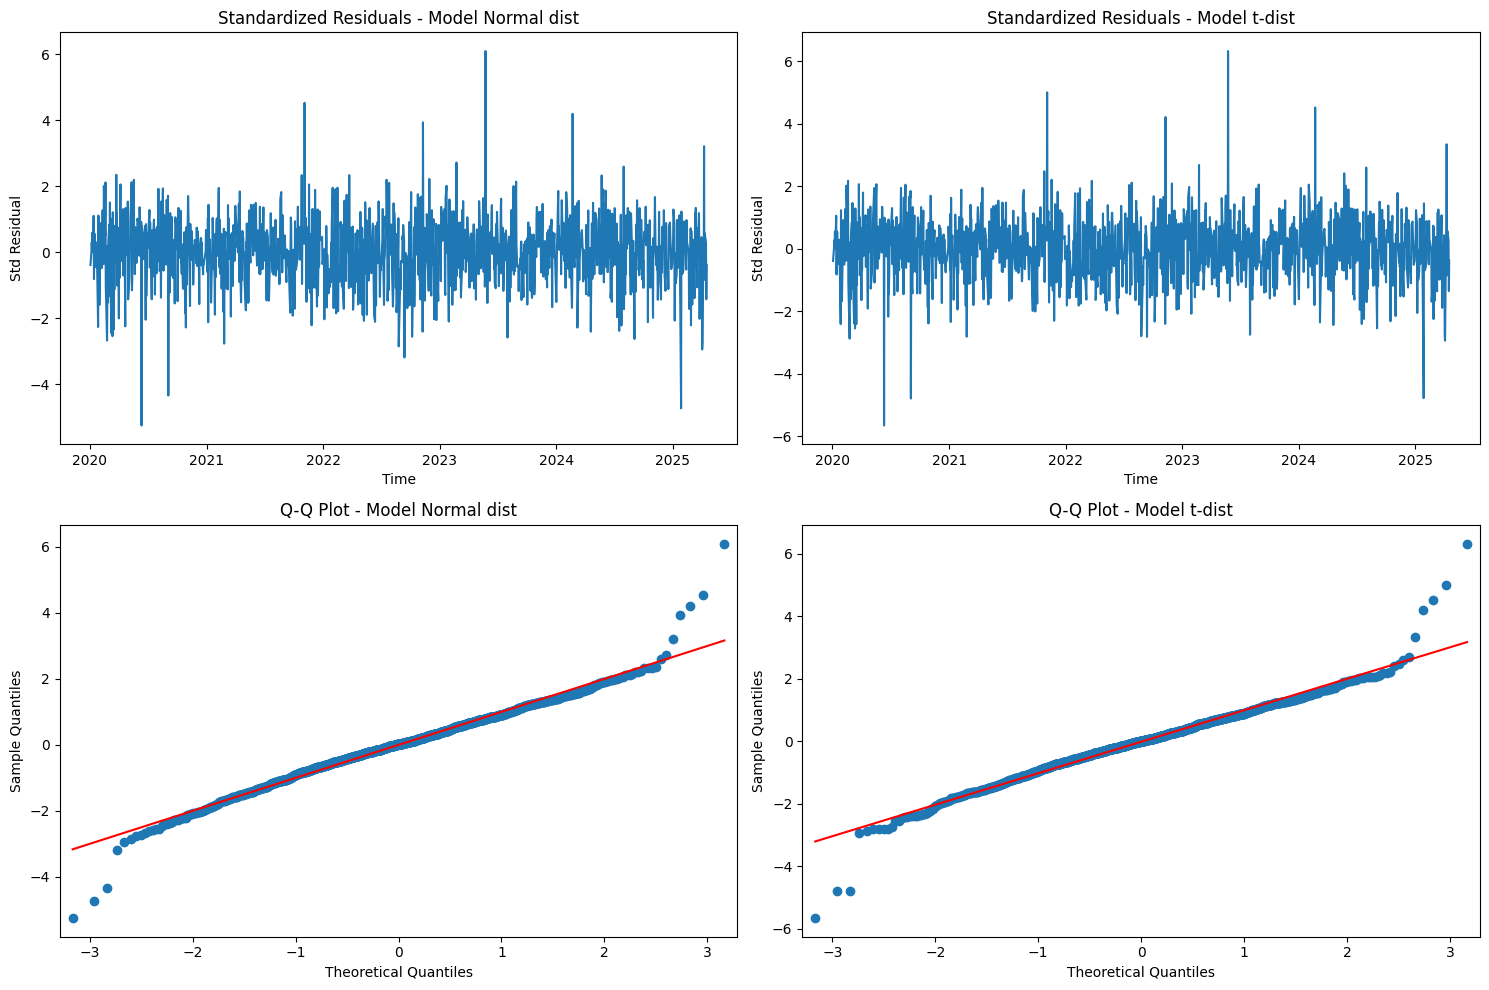

,Model,Test,Statistic,p-value,Pass
0,Model Normal dist,Ljung-Box Residuals,15.205746,1.247388e-01,True
1,Model Normal dist,Ljung-Box Squared Residuals,1.303023,9.994291e-01,True
2,Model Normal dist,Jarque-Bera,344.470200,1.582146e-75,False
3,Model t-dist,Ljung-Box Residuals,15.374896,1.189799e-01,True
4,Model t-dist,Ljung-Box Squared Residuals,1.295062,9.994446e-01,True
5,Model t-dist,Jarque-Bera,531.636557,3.602372e-116,False


In [5]:
run_diagnostics_two_models(model_result_norm, model_result_t, model_name1="Model Normal dist", model_name2="Model t-dist")

### Model Selection Summary

The best-fitting model assuming normally distributed residuals is the APARCH(2,1) model, achieving an AIC of 4560.47. Under the assumption of t-distributed residuals, the APARCH(2,1) model remains the top performer, with a slightly higher AIC of 4592.77. Diagnostic tests reveal that, for both models, the standardized residuals generally resemble white noise; however, intermittent large spikes indicate the occurrence of extreme shocks that the models fail to fully capture. Both models show comparable performance, passing the Ljung-Box tests for autocorrelation but failing the Jarque-Bera tests for normality. This failure is likely due to approximately 7 to 8 significant outliers in the tails, which correspond to the same large spikes observed in the residual plots and lead to the rejection of the null hypothesis of normality.


## 4. Simulation Methods

We will now continue on with the best model fits use them to estimate the Value-at-Risk (VaR) for both one-day and one-week horizons under three different innovation assumptions.

---

### Normal Innovations

Description: 
This method assumes that the innovations (random shocks) in returns follow a Normal (Gaussian) distribution. It is the classical assumption in many financial models, where returns are symmetrically distributed around a mean with a specific standard deviation (volatility).

Explanation:  
- The normal distribution is fully described by its mean (expected return) and variance (volatility).  
- Simulations generate returns by sampling from a normal distribution centered at the expected return with a spread defined by the model-implied volatility.  
- This approach is mathematically convenient and widely used but often criticized for underestimating the probability of extreme losses (fat tails).

### t-distributed Innovations

Description: 
Instead of assuming normality, this approach assumes that innovations follow a Student's t-distribution with a certain degrees of freedom (dof). The t-distribution allows for fatter tails, better capturing extreme events in financial returns.

Explanation:  
- The t-distribution looks like the normal distribution but has heavier tails, meaning more probability is assigned to extreme outcomes.  
- The degrees of freedom parameter controls how heavy the tails are; lower dof means fatter tails.  
- By simulating returns using the t-distribution scaled by the model volatility, this method captures the possibility of large, rare shocks better than normal innovations.  
- Many volatility models, like GARCH, estimate this dof parameter from data, improving realism.

### Filtered Historical Simulation (FHS)

Description:  
FHS is a semi-parametric approach combining model-based volatility forecasting with empirical residuals from historical data. Instead of assuming a fixed distribution, it uses the standardized residuals (filtered returns) from the fitted model as the source of randomness.

Explanation:
- The model estimates conditional volatility; residuals are standardized by dividing by their estimated volatility to remove time-varying volatility effects.  
- Future innovations are simulated by randomly resampling these historical standardized residuals (with replacement).  
- These sampled residuals are then scaled by the forecasted volatility and shifted by the expected return to produce simulated returns.  
- FHS blends parametric volatility forecasting with non-parametric empirical distribution of shocks, capturing realistic distributional features such as skewness or kurtosis inherent in the data.

Summary: 
- Normal innovations assume simple Gaussian shocks — good baseline but may underestimate tail risks.  
- t-distributed innovations incorporate heavy tails for better extreme risk modeling.  
- FHS uses the empirical distribution of standardized residuals for more flexible, data-driven simulation of shocks.

Each method has strengths and trade-offs and together they provide a robust view of potential portfolio risks.

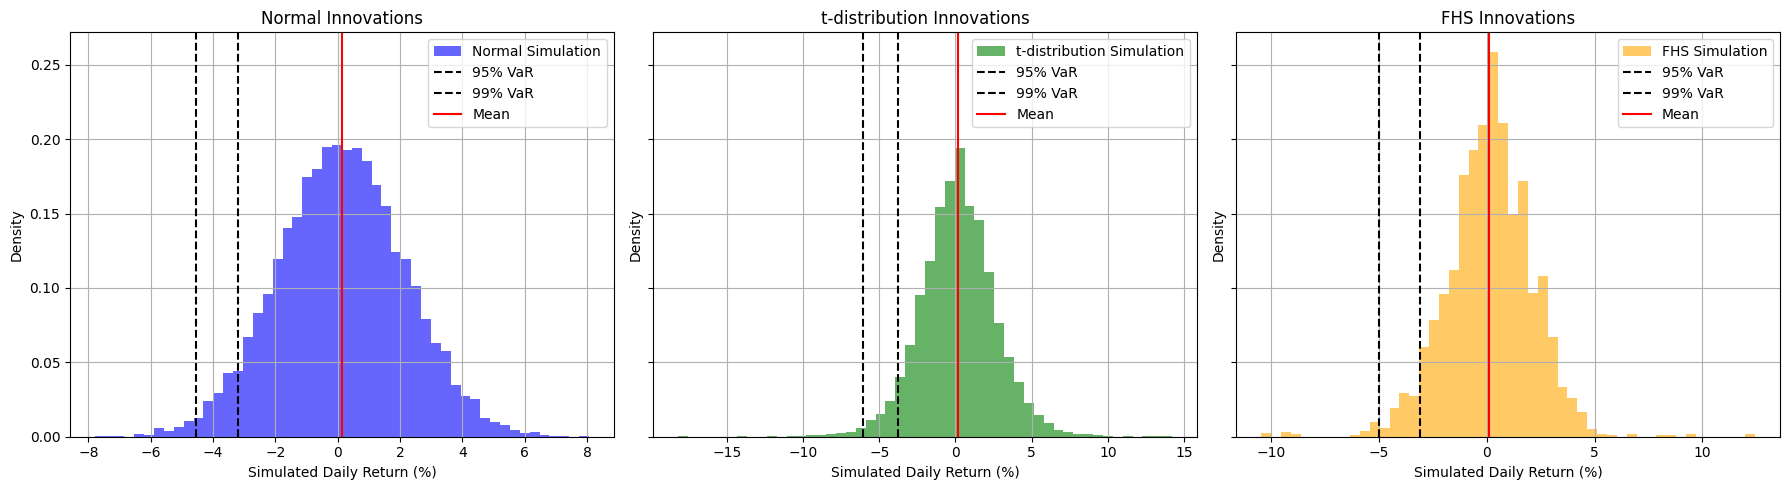

           Method  Confidence Level   VaR (%)   VaR ($)  Mean (%)
0          Normal              0.95 -3.213325 -3.213325  0.124984
1  t-distribution              0.95 -3.781123 -3.781123  0.158145
2             FHS              0.95 -3.079887 -3.079887  0.122824
3          Normal              0.99 -4.557932 -4.557932  0.124984
4  t-distribution              0.99 -6.078206 -6.078206  0.158145
5             FHS              0.99 -4.993584 -4.993584  0.122824


In [6]:
df_var = compute_var_arch_model_daily(
    model_result_norm,
    model_result_t,
    portfolio_returns,
    portfolio_value,
    simulations=10000,
    confidence_levels=[0.95, 0.99]
)
print(df_var)


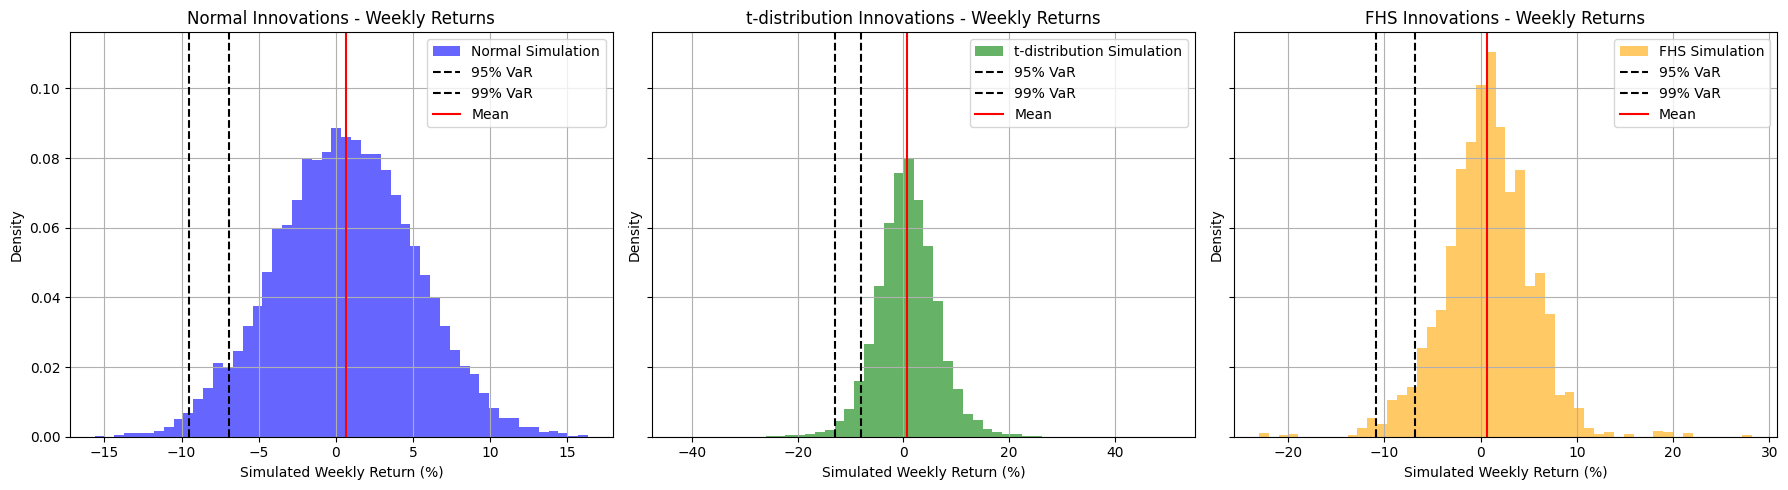

           Method  Confidence Level    VaR (%)    VaR ($)  Mean (%)
0          Normal              0.95  -6.914804  -6.914804  0.635743
1  t-distribution              0.95  -8.084756  -8.084756  0.731042
2             FHS              0.95  -6.757334  -6.757334  0.715375
3          Normal              0.99  -9.499566  -9.499566  0.635743
4  t-distribution              0.99 -12.966651 -12.966651  0.731042
5             FHS              0.99 -10.882833 -10.882833  0.715375


In [7]:
df_var = compute_var_arch_model_weekly(
    model_result_norm,
    model_result_t,
    portfolio_returns,
    portfolio_value,
    simulations=10000,
    confidence_levels=[0.95, 0.99]
)
print(df_var)


#### Summary of Daily and Weekly VaR Results

The daily Value-at-Risk (VaR) estimates indicate that under the Normal distribution assumption, the portfolio’s one-day 95% VaR is approximately -3.21%, meaning there is a 5% chance the portfolio will lose more than this in a day. Under the t-distribution assumption, which accounts for heavier tails, the 95% VaR increases to about -3.78%, reflecting a more conservative risk estimate. The Filtered Historical Simulation (FHS), which uses empirical residuals from the model, produces a 95% VaR close to -3.08%. At the 99% confidence level, these values increase, with the t-distribution VaR rising significantly to around -6.01%.

For the weekly horizon, VaR estimates are notably larger, as expected with longer time frames. The Normal assumption yields a 95% weekly VaR near -6.91%, while the t-distribution estimates a higher risk with a 95% VaR around -8.08%. FHS again sits between these values, giving a 95% VaR close to -6.76%. At 99% confidence, the weekly VaR rises substantially, with the t-distribution estimate reaching nearly -13%, signaling the increased probability of extreme losses over a week.

Mean simulated returns scale approximately linearly with time horizon, with weekly means roughly four to five times daily means, reflecting accumulated expected returns.



#### Comparison and Interpretation

Comparing daily and weekly VaR results highlights the natural increase in potential losses over a longer horizon, roughly doubling or more when moving from daily to weekly estimates across all models and confidence levels. This demonstrates that risk accumulates over time, an essential consideration for portfolio risk management.

The t-distribution consistently produces higher VaR values than the Normal distribution, underscoring the importance of accounting for fat tails and extreme events in financial returns. The Filtered Historical Simulation method offers a middle ground, leveraging observed residuals to capture the empirical distribution of returns without strict parametric assumptions.

The results emphasize the impact of distributional assumptions on risk estimates. Using solely Normal assumptions risks underestimating tail risk, while t-distributions and FHS provide more robust, conservative measures.

Overall, combining parametric approaches (Normal and t) with non-parametric methods (FHS) provides a richer, more comprehensive understanding of portfolio risk across time horizons. This multifaceted approach supports better-informed risk management decisions by capturing different facets of return behavior and uncertainty.


## Conclusion and Future Work
This project successfully implemented Value-at-Risk (VaR) estimation using a range of ARCH-family volatility models, focusing on daily and weekly horizons with Normal, t-distributed, and Filtered Historical Simulation (FHS) innovations. The best fitting model, APARCH(2,1), provided consistent and interpretable VaR estimates across confidence levels, enabling practical and robust risk assessment of the portfolio.

The comprehensive diagnostic analysis conducted revealed that standardized residuals generally behave like white noise, affirming the models’ adequacy in capturing volatility clustering and asymmetric effects inherent in financial returns. However, occasional large residual spikes indicate extreme shocks not fully captured, which contributed to the failure of normality tests (Jarque-Bera), underscoring challenges in modeling extreme tail risk. Both models passed autocorrelation tests (Ljung-Box), confirming the absence of significant serial correlation in residuals.

Despite these strengths, important limitations persist. The reliance on historical data and the assumption of stationarity constrain the models’ ability to predict sudden structural breaks or rare tail events. Moreover, the use of Normal and t-distribution innovations may still underestimate tail risks under stressed market conditions.

Future extensions should include monthly VaR estimation to address longer-term risk horizons and the integration of interactive tools for real-time parameter tuning to enhance model flexibility and user engagement. Continued development of stress testing frameworks and thorough backtesting on historical crises and out-of-sample data will further validate model performance and increase confidence in practical applications.

By addressing these factors, the robustness and credibility of VaR estimation will be enhanced, ultimately supporting more informed and effective risk management decisions in volatile and evolving financial markets.